# START HERE

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,\
BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import splitfolders

In [2]:
def fetch_files_names(directory):
    subfolders_path = [ f.name for f in os.scandir(directory) if f.is_dir() ]
    return subfolders_path

In [3]:
# directory of the base folder
dir = 'data/clean_data/'
# Create a dictionary with mashrooms and labels
CLASSES = dict(zip(fetch_files_names(dir), np.arange(0, len(fetch_files_names(dir)))))

In [5]:
# give the directory that includes folders of images and return three files split in train test validation

def split_data(dir = dir, output = dir + "/../output"):
    """
    Split data in train, test, validataion
    """
    splitfolders.ratio(dir , output=output, seed=1337, ratio=(.75, 0.15,0.1)) 


In [6]:
split_data()
train_path = dir + "/../output" + '/train/'
test_path = dir + "/../output" + '/test/'
valid_path = dir + "/../output" + '/val/'

Copying files: 26817 files [02:41, 166.13 files/s]


In [7]:
# prepare data for the model in batches to avoid RAM problems
train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2) 
train_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=CLASSES, batch_size=64,subset='training')

validation_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=CLASSES, batch_size=64,subset='validation')

test_batches = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(\
directory=test_path, target_size=(224,224), classes=CLASSES, \
batch_size=64, shuffle=False)

Found 16094 images belonging to 26 classes.
Found 4009 images belonging to 26 classes.
Found 2705 images belonging to 26 classes.


In [43]:
test_batches[0]

(array([[[[0.5372549 , 0.53333336, 0.5529412 ],
          [0.5294118 , 0.5254902 , 0.54509807],
          [0.54509807, 0.5411765 , 0.56078434],
          ...,
          [0.0509804 , 0.0509804 , 0.01176471],
          [0.05882353, 0.05490196, 0.03529412],
          [0.02745098, 0.01176471, 0.01568628]],
 
         [[0.5254902 , 0.52156866, 0.5411765 ],
          [0.5254902 , 0.52156866, 0.5411765 ],
          [0.5372549 , 0.53333336, 0.5529412 ],
          ...,
          [0.05882353, 0.05882353, 0.01960784],
          [0.07058824, 0.07058824, 0.03921569],
          [0.09019608, 0.07058824, 0.05882353]],
 
         [[0.5254902 , 0.5254902 , 0.53333336],
          [0.5254902 , 0.5254902 , 0.53333336],
          [0.5137255 , 0.5137255 , 0.52156866],
          ...,
          [0.09019608, 0.09019608, 0.04313726],
          [0.06666667, 0.05490196, 0.01960784],
          [0.12156864, 0.09411766, 0.07058824]],
 
         ...,
 
         [[0.00784314, 0.00784314, 0.        ],
          [0.01176

# MODEL ResNet50V2

In [8]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_ResNet50V2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = ResNet50V2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_ResNet50V2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/ResNet50V2_test.h5') 
    return model, history


In [ ]:
model = model_ResNet50V2(learning_rate=0.001)
model, history = fit_ResNet50V2(epochs = 200)

# Evaluate model

In [49]:
model=keras.models.load_model(
    "models/ResNet50V2_001_200_100.h5")

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 26)                3354      
                                                                 
Total params: 23,707,610
Trainable params: 142,810
Non-t

- - import json
- Get the dictionary containing each metric and the loss for each epoch
- - history_dict = history_model_1.history
- Save it under the form of a json file
- - json.dump(history_dict, open(your_history_path, 'w'))

- Reload
- - history_dict = json.load(open(your_history_path, 'r'))
- - print(history_dict['loss'][49])

In [25]:
losses_accurs = pd.DataFrame(history.history)

losses_accurs[['loss', 'val_loss']].plot()
plt.title('Train and Test (val) Loss')
plt.xlabel('epochs')
plt.show()

losses_accurs[['accuracy', 'val_accuracy']].plot()
plt.title('Train and Test (val) Accuracy')
plt.xlabel('epochs')
plt.show()


# alternative

# Plot model accuracy and loss:
pd.DataFrame(history.history).plot()

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
pd.DataFrame(history.history)

# Presiction

In [76]:
def get_label(key ,class_mush ):
    """
    You can get the labeled name of the mushroom by giving 
    the index or the index by giving the key
    """
    if type(key) == str:
        return class_mush[key]
    elif type(key) == int:
        return list(class_mush.keys())[list(class_mush.values()).index(key)]

In [77]:
def fetch_image(subdirectory):
    onlyfiles = [f for f in listdir(subdirectory) if isfile(join(subdirectory, f))]
    #label = np.full((1, len(onlyfiles)), get_label(onlyfiles))#.ravel()
    return onlyfiles#, label

In [82]:
def image_classification(image_path, model):
    image = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    pic_array = keras.preprocessing.image.img_to_array(image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = keras.applications.resnet_v2.preprocess_input(image_batch)
    probs = model.predict(processed_image)[0].tolist()
    zipped = sorted(list(zip(CLASSES, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [86]:
def choose_test_file(direct = 'data/output/train/' + 'Amanita/',val = 45, model = model):
    test = fetch_image(direct)
    item = cv2.imread(direct+ test[val])
    plt.imshow(item,cmap='Greys')
    image_classification(direct+ test[val], model)


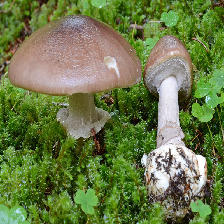

In [84]:
img_test = keras.preprocessing.image.load_img(direct+ test[val], target_size=(224,224))
img_test

,image_class,probability(%)
0,Clitocybe_nebularis,88.928449
1,Auricularia_auricula-judae,5.205223
2,Amanita,2.342039
3,Hypholoma_fasciculare,1.062809
4,Hygrocybe,0.998000
5,Pleurotus_ostreatus,0.593043
6,Gymnopilus_penetrans,0.394107
7,Agaricus,0.156559
8,Mycena_galericulata,0.112019
9,Boletus,0.105588


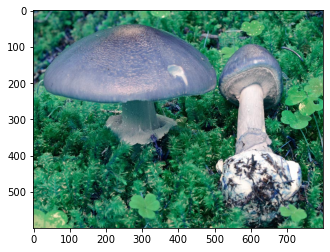

In [87]:
direct = 'data/output/train/Amanita/'
val = 45
choose_test_file(direct = direct)
tf.autograph.experimental.do_not_convert
image_classification(direct+ fetch_image(direct)[val], model)


# Model MobileNetV2

In [ ]:
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_InceptionResNetV2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = InceptionResNetV2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_ResNet50V2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/ResNet50V2_test.h5') 
    return model, history
